# Sentimental analysis

The goal of this project was to apply a range of natural language processing (NLP) methods, such as Latent Dirichlet Allocation (LDA) for topic modeling, to analyze the sentiment of reviews from **Netflix**. 

The dataset was first preprocessed using various text-cleaning methods with the NLTK library. LDA was then used to identify prominent topics, which were visualized using PyLDAvis. Finally, sentiment analysis was performed with the TextBlob library to gain insights into the underlying sentiments expressed in the reviews.

## Import required packages

In [203]:
import pandas as pd  # Data manipulation and analysis (pip install pandas)
import re # essential library for text processing tasks
import string
import numpy as np  # Numerical computations, arrays, and matrices (pip install numpy)
import matplotlib.pyplot as plt  # Plotting and visualizations (pip install matplotlib)
import matplotlib as mpl
import seaborn as sns
import nltk # NLP toolkit; for tokenization, stopword removal (pip install nltk)
from nltk.tokenize import sent_tokenize, word_tokenize, MWETokenizer # Tokenizers for single/multi-word expressions
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
# nltk.download('all')
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder  # Bigram collocation finder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder  # Trigram collocation finder
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
# PyTorch currently supports Python versions up to 3.11. 
# Ensure your Python version is 3.11 or lower to avoid compatibility issues.
#!pip install torch torchvision 
import torch
import torchvision
from tqdm.notebook import tqdm
import gensim  # Topic modeling and document similarity (pip install gensim)
from sklearn.decomposition import  LatentDirichletAllocation #(pip install scikit-learn)
# (not used) from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS  # Stopword removal (Gensim's list is extensive)
from gensim import corpora  # Corpus and dictionary creation for topic modeling
from textblob import TextBlob  # Sentiment analysis and text processing (pip install textblob)
from wordcloud import WordCloud  # Creates word cloud visuals (pip install wordcloud)
import pyLDAvis  # Interactive LDA visualization (pip install pyLDAvis)
import pyLDAvis.gensim
import warnings  # Suppresses deprecation warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
plt.style.use('ggplot')
sia = SentimentIntensityAnalyzer()

## Data Loading and High-Level EDA

In [204]:
df=pd.read_csv('data/netflix_reviews.csv')
df = df.head(900)
df.head()
#df['content_len'] = df['content'].apply(lambda x: len(x.split(' ')))
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,28f0b8f2-bb2d-4f68-8255-d61be1084067,Ram Sandeep,Not working,1,0,8.139.1 build 24 51108,2024-11-08 13:33:35,8.139.1 build 24 51108
1,a139e6b1-0160-4805-8f65-30447a3e4f93,Donald Chagut,mabviravira,5,0,NaN,2024-11-08 13:15:46,NaN
2,3ea9f296-2ef0-408c-8fdc-077d03ee7569,Mohd Shaifudin Mohd Ali,Oky,5,0,8.139.1 build 24 51108,2024-11-08 13:02:46,8.139.1 build 24 51108
3,e8290100-4afa-444f-8568-9a9b94682d2e,Gerardo Ruvalcaba,More expensive and more restrictions,1,0,8.139.1 build 24 51108,2024-11-08 12:58:01,8.139.1 build 24 51108
4,47c91094-d3bd-4c73-b5ba-211ca6ea5e4f,Clainah Briones,While watching it will suddenly stop playing i...,1,0,8.139.1 build 24 51108,2024-11-08 12:46:57,8.139.1 build 24 51108


In [205]:
df.head()
df.describe(include='object')

,reviewId,userName,content,reviewCreatedVersion,at,appVersion
count,900,900,900,665,900,665
unique,897,890,820,83,900,83
top,81c756ff-c1d7-4e98-913c-619be0f3c39d,A Google user,Good,8.138.1 build 10 50974,2024-11-08 13:33:35,8.138.1 build 10 50974
freq,2,6,28,297,1,297


<Axes: title={'center': 'Count of reviews by Score'}, xlabel='score'>

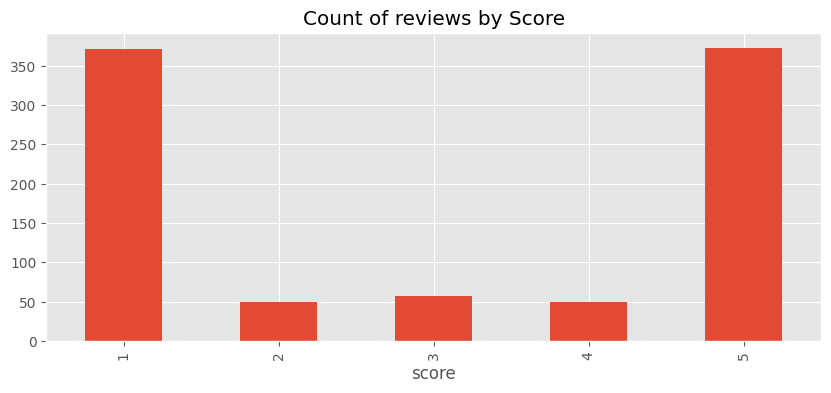

In [206]:
# Set the width and height of the figure
plt.figure(figsize=(10,4))
# Add title
plt.title("Count of reviews by Score")
df['score'].value_counts().sort_index().plot(kind='bar')

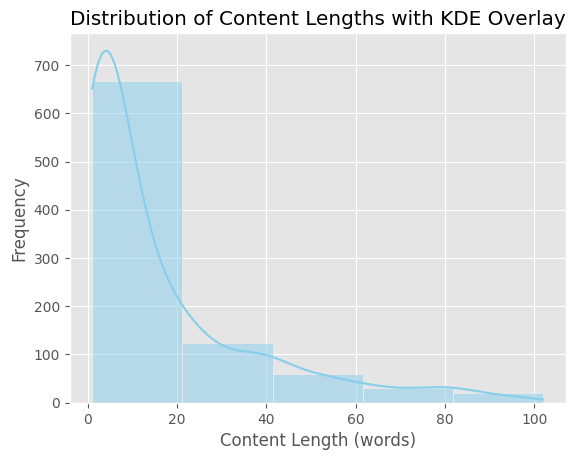

In [207]:
sns.histplot(df['content'].apply(lambda x: len(x.split(' '))), bins=5, kde=True, color='skyblue')
plt.xlabel("Content Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Content Lengths with KDE Overlay")
plt.show()

## Basic NLTK

In this section, we will cover the basic Natural Language Processing (NLP) tasks:

1. **Text Cleaning and Preprocessing** - converting text to lowercase, removing punctuation, and filtering out non-alphanumeric characters.

2. **Stop Words Removal** - stop words are common words (like "and", "the", "is") that are often removed as they don’t add significant meaning to the text

3. **Lemmatization**  - reduces words to their root forms ( we will use `WordNetLemmatizer` )

4. **POS Tagging (Part-of-Speech Tagging)** - assigns parts of speech (e.g., noun, verb, adjective) to each word in a sentence, which helps in understanding the grammatical structure. (We will use `pos_tag`)

5. **Tokenization** - splits text into smaller components, usually words or sentences ( `word_tokenize` for word-level tokenization and `sent_tokenize` for sentence-level tokenization)

6. **Collocation** - identify common phrases or expression

7. **Frequency Distribution** - a count of how frequently each word or token appears in a text. ( `FreqDist` function is used )

8. **Basic Corpus Access** - A corpus is a large collection of texts. NLTK provides access to several standard corpora (e.g., Gutenberg, Brown) that are useful for practice and experimentation.

### **Text Cleaning and Preprocessing** 

In [208]:
def process_review(review):
    ''' Process review text by:
    - Converting to lowercase
    - Removing text in square brackets
    - Removing links
    - Removing punctuation
    - Removing newline characters
    - Removing words containing numbers
    - Removing HTML tags'''
    review = str(review).lower() # Make text lowercase
    review = re.sub(r'\[.*?\]', '', review)  # Remove text in square brackets
    review = re.sub(r'https?://\S+|www\.\S+', '', review)  # Remove URLs
    review = re.sub(r'<.*?>+', '', review)  # Remove HTML tags
    review = re.sub(rf"[{re.escape(string.punctuation)}]", '', review)  # Remove punctuation
    review = re.sub(r'\n', ' ', review)  # Replace newline characters with space
    review = re.sub(r'\w*\d\w*', '', review)  # Remove words containing digits
    review = re.sub(r'[\U0001F600-\U0001F64F]', '', review)  # Emoticons
    review = re.sub(r'[\U0001F300-\U0001F5FF]', '', review)  # Symbols & Pictographs
    review = re.sub(r'[\U0001F680-\U0001F6FF]', '', review)  # Transport & Map Symbols
    review = re.sub(r'[\U0001F700-\U0001F77F]', '', review)  # Alchemical Symbols
    review = re.sub(r'[\U0001F780-\U0001F7FF]', '', review)  # Geometric Shapes Extended
    review = re.sub(r'[\U0001F800-\U0001F8FF]', '', review)  # Supplemental Arrows-C
    review = re.sub(r'[\U0001F900-\U0001F9FF]', '', review)  # Supplemental Symbols and Pictographs
    review = re.sub(r'[\U0001FA00-\U0001FA6F]', '', review)  # Chess Symbols
    review = re.sub(r'[\U0001FA70-\U0001FAFF]', '', review)  # Symbols and Pictographs Extended-A
    review = re.sub(r'[\U00002702-\U000027B0]', '', review)  # Dingbats
    review = re.sub(r'[\U000024C2-\U0001F251]', '', review)  # Enclosed characters
    return review 


### Stop Words Removal &  Lematization & POS Tagging 

I chose **lemmatization** over **stemming** because:

- Lemmatization returns actual words that preserve meaning (e.g., "better" becomes "good" rather than "bet" or "bett"), making the text easier to analyze. 
Stemming often produces incomplete forms, like "happi" instead of "happy."
- Lemmatization considers context and part of speech, improving accuracy in sentiment analysis.

In [222]:

stop_words = set(nltk.corpus.stopwords.words('english'))
# print(stop_words)

custom_stopwords = [ 'movie', 'film', 'series']
def remove_stopwords(review):
    review = ' '.join(word for word in review.split(' ') if word not in stop_words and word not in custom_stopwords and len(word)>3)
    return review

lemmatizer = WordNetLemmatizer()
# Helper function to get WordNet POS tag
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if POS tag not found

# Function to lemmatize each word in a review
def lemmatize_review(review):
    # Tokenize the review into words
    words = word_tokenize(review)
    # Lemmatize each word with its corresponding POS tag
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    # Join the lemmatized words back into a single string
    return ' '.join(lemmatized_words)


# df['clean_content'] = df['clean_content'].apply(remove_stopwords).apply(lemmatize_review)

# pd.set_option('display.max_rows', None)
# df.head(5)

### Tokenization & Collocation & Frequency Distribution

bigrams (pairs of words that frequently appear together)  can reveal more context than single words alone. 

For example:

In Netflix reviews, bigrams like "great show" or "poor quality" can highlight common sentiments.
Bigrams can help identify popular features, issues, or specific themes (e.g., "customer service" or "slow loading").
They capture patterns of expression that individual words alone might miss, offering better insights into user experiences and sentiments.

**Tokenization** - splits text into smaller components, usually words or sentences
   - Common functions include `word_tokenize` for word-level tokenization and `sent_tokenize` for sentence-level tokenization

6. **Collocation** - identify common phrases or expression

7. **Frequency Distribution** - a count of how frequently each word or token appears in a text.
   - The `FreqDist` function is used 
   
8. **Basic Corpus Access** - A corpus is a large collection of texts. NLTK provides access to several standard corpora (e.g., Gutenberg, Brown) that are useful for practice and experimentation.

In [230]:
# Process the text data by tokenizing and cleaning
all_tokens = []
for text in df['clean_content']:
    # Tokenize, lowercase, and remove stopwords and punctuation
    tokens = [word.lower() for word in nltk.word_tokenize(text) if word.lower() not in stop_words and word not in string.punctuation]
    all_tokens.extend(tokens)  # Add to the list of all tokens

# Initialize BigramCollocationFinder with the tokenized words
bigram_collocation = BigramCollocationFinder.from_words(all_tokens)

# Apply a frequency filter (e.g., keep only bigrams appearing at least 3 times)
bigram_collocation.apply_freq_filter(7)

# Find the most common bigrams based on a scoring metric like PMI
top_bigrams = bigram_collocation.nbest(BigramAssocMeasures.pmi, 30)  # Change 15 to desired number of top bigrams

print("Top bigrams by common use:", top_bigrams)

Top bigrams by common use: [('customer', 'service'), ('even', 'though'), ('dont', 'know'), ('many', 'time'), ('doesnt', 'work'), ('dont', 'want'), ('cant', 'even'), ('love', 'netflix'), ('good', 'movie'), ('watch', 'movie'), ('good', 'good'), ('watch', 'show'), ('watch', 'netflix')]


In [223]:
# Lets apply all modernisations to content column
df['clean_content'] = df['content'].apply(process_review).apply(remove_stopwords).apply(lemmatize_review)
df.head(10)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,clean_content
0,28f0b8f2-bb2d-4f68-8255-d61be1084067,Ram Sandeep,Not working,1,0,8.139.1 build 24 51108,2024-11-08 13:33:35,8.139.1 build 24 51108,work
1,a139e6b1-0160-4805-8f65-30447a3e4f93,Donald Chagut,mabviravira,5,0,NaN,2024-11-08 13:15:46,NaN,mabviravira
2,3ea9f296-2ef0-408c-8fdc-077d03ee7569,Mohd Shaifudin Mohd Ali,Oky,5,0,8.139.1 build 24 51108,2024-11-08 13:02:46,8.139.1 build 24 51108,
3,e8290100-4afa-444f-8568-9a9b94682d2e,Gerardo Ruvalcaba,More expensive and more restrictions,1,0,8.139.1 build 24 51108,2024-11-08 12:58:01,8.139.1 build 24 51108,expensive restriction
4,47c91094-d3bd-4c73-b5ba-211ca6ea5e4f,Clainah Briones,While watching it will suddenly stop playing i...,1,0,8.139.1 build 24 51108,2024-11-08 12:46:57,8.139.1 build 24 51108,watch suddenly stop play like video freeze sou...
5,46edbac0-b173-456d-a41e-c53f68ef216a,Vanessa Mutya,Nice,5,0,8.139.1 build 24 51108,2024-11-08 12:44:42,8.139.1 build 24 51108,nice
6,bdeabd90-185a-4d5f-9eea-1932a83097f4,Akshay Madane,Login problem.. Very lengthy process,1,0,NaN,2024-11-08 12:42:51,NaN,login problem lengthy process
7,223a5b0e-d3d3-4bf1-af31-9143777a7afa,Cabus Archie,"Rate to the lowest, I downloaded some movies a...",1,0,8.138.1 build 10 50974,2024-11-08 12:34:57,8.138.1 build 10 50974,rate low download movie go unannounced waste m...
8,5210bf25-3a73-48e0-91d3-5543e0d0ac6b,M J,Pirate everything,1,0,8.127.1 build 10 50788,2024-11-08 12:19:47,8.127.1 build 10 50788,pirate everything
9,d67cadf0-3091-49ee-8608-5aa0dd17fc60,Jayden John,"I like it, but can you add more english dub on...",5,0,8.120.0 build 10 50712,2024-11-08 12:18:13,8.120.0 build 10 50712,like english piece season


In [224]:
biagram_collocation = BigramCollocationFinder.from_words(df['clean_content'])
biagram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 15)

[('able view movie scroll suck inqired nothing ihardly ever useit gon na delete solutiondoesnt come soon updatesame result',
  'love netflix enjoy watch movie'),
 ('absolute clown', 'best business'),
 ('absolutely fantastic thank much',
  'would remove friend show thats literally best part netflix remove'),
 ('absolutely nothing south african watch lot nonsense upload really',
  'video stop second audio carry start october update store'),
 ('absolutely rubbish avoid', 'love remove prepy kawaii lorax like whatt'),
 ('add normal', 'longer cast google chrome'),
 ('addssssssss', 'dont option rupay card'),
 ('adoi pen boleh beli membership boleh buat macam mana kene suruh tapi still takleh',
  'cant google play money'),
 ('agenda real show', 'gauravparikh'),
 ('agenda supporter', 'good didnt need add'),
 ('allow watch show watch account', 'agenda supporter'),
 ('although absolutely love face problem whenever want watch take atleast min open sometimes even min',
  'isnt worth anymore decide 

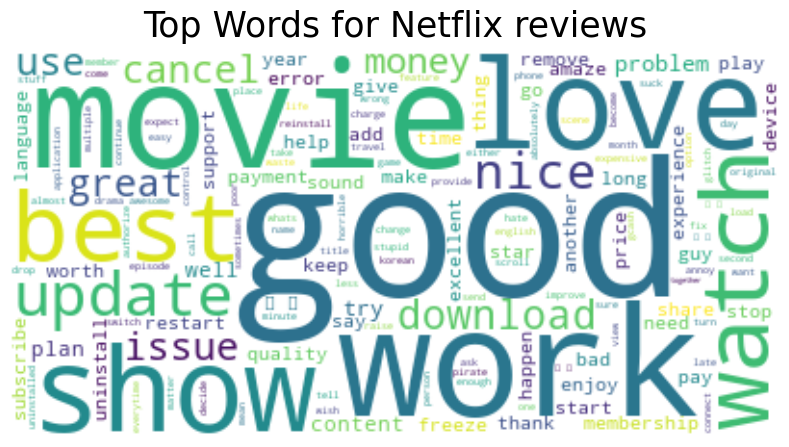

In [220]:
from PIL import Image
# Ensure 'clean_content' column exists and has no NaN values
text_data = ' '.join(df['clean_content'].dropna())

# Load the mask
netflix_mask = np.array(Image.open('mask.png'))

# Create the WordCloud object
wc = WordCloud(
    background_color='white', 
    max_words=200, 
    #mask=netflix_mask,
)

# Generate the word cloud
wc.generate(text_data)

# Plot the word cloud
plt.figure(figsize=(15, 5))
plt.title('Top Words for Netflix reviews', 
          fontdict={'size': 25, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [212]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(review):
    review = ' '.join(stemmer.stem(word) for word in review.split(' '))
    return review

In [213]:
example=df['content'][190]
print(example)
tokens = nltk.word_tokenize(example)
print(tokens)

The new update sucks . What is wrong with netflix ? The subscription money got wasted !!
['The', 'new', 'update', 'sucks', '.', 'What', 'is', 'wrong', 'with', 'netflix', '?', 'The', 'subscription', 'money', 'got', 'wasted', '!', '!']


In [214]:
#nltk.help.brown_tagset()
tagged=nltk.pos_tag(tokens)

In [215]:
entities=nltk.chunk.ne_chunk(tagged)
print(entities)

(S
  The/DT
  new/JJ
  update/JJ
  sucks/NNS
  ./.
  What/WP
  is/VBZ
  wrong/JJ
  with/IN
  netflix/NN
  ?/.
  The/DT
  subscription/NN
  money/NN
  got/VBD
  wasted/JJ
  !/.
  !/.)


In [216]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)